### Import packages

In [107]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.regression import LabeledPoint
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.sql import Row
from time import *
from pyspark.sql import Row
from pyspark.ml.linalg import Vectors

### Set up import data type for each field

In [108]:
schema_structtype_final = StructType([
 StructField("index",IntegerType(),True),
 StructField("msno",IntegerType(),True),
 StructField("song_id",IntegerType(),True),
 StructField("source_system_tab",IntegerType(),True),
 StructField("source_system_name",IntegerType(),True),
 StructField("source_type",IntegerType(),True),
 StructField("target",FloatType(),True),
 StructField("song_length",FloatType(),True),
 StructField("genre_ids",IntegerType(),True),
 StructField("artist_name",IntegerType(),True),
 StructField("composer",IntegerType(),True),
 StructField("lyricist",IntegerType(),True),
 StructField("language",IntegerType(),True),
 StructField("city",IntegerType(),True),
 StructField("bd",IntegerType(),True),
 StructField("gender",IntegerType(),True),
 StructField("registered_via",IntegerType(),True),
 StructField("registration_init_time",StringType(),True),
 StructField("expiration_date",StringType(),True),
 StructField("time",FloatType(),True)
])

### Import train/ test data

In [109]:
train = spark.read.schema(schema_structtype_final).csv("train.csv").cache()

In [110]:
test = spark.read.schema(schema_structtype_final).csv("test.csv").cache()

In [111]:
train = train.drop("index") \
             .filter(train["msno"].isNotNull())

In [112]:
test = test.drop("index") \
             .filter(test["msno"].isNotNull())

In [113]:
# Adjust the order of columns
train = train.select(['msno','song_id',
 'source_system_tab',
 'source_system_name',
 'source_type',
 'song_length',
 'genre_ids',
 'artist_name',
 'composer',
 'lyricist',
 'language',
 'city',
 'bd',
 'gender',
 'registered_via',
 'registration_init_time',
 'expiration_date',
 'time','target'])

### Model 1: Random Forest

In [114]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [115]:
train = train.dropna()

In [116]:
train.columns

['msno',
 'song_id',
 'source_system_tab',
 'source_system_name',
 'source_type',
 'song_length',
 'genre_ids',
 'artist_name',
 'composer',
 'lyricist',
 'language',
 'city',
 'bd',
 'gender',
 'registered_via',
 'registration_init_time',
 'expiration_date',
 'time',
 'target']

In [117]:
# Drop target and not necessary columns to create features
featuresCols = train.drop("target").drop("expiration_date").drop("registration_init_time").columns
assembler = VectorAssembler(inputCols = featuresCols, outputCol="features")

In [78]:
featuresCols

['msno',
 'song_id',
 'source_system_tab',
 'source_system_name',
 'source_type',
 'song_length',
 'genre_ids',
 'artist_name',
 'composer',
 'lyricist',
 'language',
 'city',
 'bd',
 'gender',
 'registered_via',
 'time']

In [13]:
# Transfer data into features 
# assembled = assembler.transform(train)

In [119]:
# Set up Random Forest model
rf = RandomForestClassifier(numTrees=100, maxDepth=5, labelCol="target",featuresCol="features",seed=42)

In [120]:
# Pipeline
pipeline = Pipeline(stages=[assembler, rf])

In [16]:
# Split data and prepare for modeling 
# use a 70-30 random split here for training and testing data sets respectively, then verify their sizes
# (train, validation) = assembled.randomSplit([0.7, 0.3], seed=1234)

In [17]:
# assembled.columns

['msno',
 'song_id',
 'source_system_tab',
 'source_system_name',
 'source_type',
 'song_length',
 'genre_ids',
 'artist_name',
 'composer',
 'lyricist',
 'language',
 'city',
 'bd',
 'gender',
 'registered_via',
 'registration_init_time',
 'expiration_date',
 'time',
 'target',
 'features']

In [121]:
# Fit model on train data
pipe_model = pipeline.fit(train)

In [122]:
type(pipe_model)

pyspark.ml.pipeline.PipelineModel

In [123]:
rfc = pipe_model.stages[-1]

In [124]:
# Use the fitted model to obtain predictions on the validation set
predictions = pipe_model.transform(train)

In [130]:
predictions.limit(10).toPandas()

/opt/spark/current/python/pyspark/sql/dataframe.py:2102: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


,msno,song_id,source_system_tab,source_system_name,source_type,song_length,genre_ids,artist_name,composer,lyricist,...,gender,registered_via,registration_init_time,expiration_date,time,target,features,rawPrediction,probability,prediction
0,9176,86884,7,1,7,206471.0,307,3784,16653,26024,...,2,2,2012-01-02,2017-10-05,0.000000e+00,1.0,"[9176.0, 86884.0, 7.0, 1.0, 7.0, 206471.0, 307...","[56.91017810239456, 43.089821897605425]","[0.5691017810239457, 0.4308982189760543]",0.0
1,19273,260594,8,3,4,284584.0,97,36867,74276,26024,...,0,3,2011-05-25,2017-09-11,1.006623e-07,1.0,"[19273.0, 260594.0, 8.0, 3.0, 4.0, 284584.0, 9...","[31.00235513368335, 68.99764486631668]","[0.3100235513368334, 0.6899764486631665]",1.0
2,19273,140755,8,3,4,225396.0,97,24601,51540,26024,...,0,3,2011-05-25,2017-09-11,2.013246e-07,1.0,"[19273.0, 140755.0, 8.0, 3.0, 4.0, 225396.0, 9...","[30.94661839037719, 69.05338160962285]","[0.3094661839037718, 0.6905338160962282]",1.0
3,19273,27577,8,3,4,255512.0,6,31651,41991,26024,...,0,3,2011-05-25,2017-09-11,3.019868e-07,1.0,"[19273.0, 27577.0, 8.0, 3.0, 4.0, 255512.0, 6....","[31.879695709092744, 68.12030429090727]","[0.31879695709092737, 0.6812030429090726]",1.0
4,9176,38706,7,1,7,187802.0,2,5190,9701,26024,...,2,2,2012-01-02,2017-10-05,4.026491e-07,1.0,"[9176.0, 38706.0, 7.0, 1.0, 7.0, 187802.0, 2.0...","[56.687812833684454, 43.31218716631553]","[0.5668781283368446, 0.43312187166315536]",0.0
5,9176,35087,7,1,7,247803.0,97,9452,63673,26024,...,2,2,2012-01-02,2017-10-05,5.033114e-07,1.0,"[9176.0, 35087.0, 7.0, 1.0, 7.0, 247803.0, 97....","[57.239874223055494, 42.76012577694449]","[0.572398742230555, 0.42760125776944496]",0.0
6,19273,221459,8,3,4,229982.0,371,3348,66331,22941,...,0,3,2011-05-25,2017-09-11,6.039737e-07,1.0,"[19273.0, 221459.0, 8.0, 3.0, 4.0, 229982.0, 3...","[30.5715813536059, 69.42841864639409]","[0.305715813536059, 0.694284186463941]",1.0
7,9176,258674,7,1,7,181115.0,2,35342,67760,26024,...,2,2,2012-01-02,2017-10-05,7.046360e-07,1.0,"[9176.0, 258674.0, 7.0, 1.0, 7.0, 181115.0, 2....","[57.239874223055494, 42.76012577694449]","[0.572398742230555, 0.42760125776944496]",0.0
8,31394,10642,8,3,3,278964.0,200,25767,60384,26024,...,1,3,2011-11-07,2018-03-04,8.052982e-07,1.0,"[31394.0, 10642.0, 8.0, 3.0, 3.0, 278964.0, 20...","[31.015320705281834, 68.98467929471819]","[0.31015320705281824, 0.6898467929471818]",1.0
9,31394,109197,8,3,3,257369.0,371,25767,60384,26024,...,1,3,2011-11-07,2018-03-04,9.059605e-07,1.0,"[31394.0, 109197.0, 8.0, 3.0, 3.0, 257369.0, 3...","[30.768388688754307, 69.23161131124571]","[0.307683886887543, 0.692316113112457]",1.0


### Model Evaluation

In [126]:
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

def evaluation_metric(prediction):
    
    multieval = MulticlassClassificationEvaluator(labelCol='target')
    bieval = BinaryClassificationEvaluator(labelCol='target')
    auc = bieval.evaluate(prediction, {bieval.metricName: "areaUnderROC"})
    f1 = multieval.evaluate(prediction, {multieval.metricName: "f1"})
    accuracy = multieval.evaluate(prediction, {multieval.metricName: "accuracy"})
    weighted_precision = multieval.evaluate(prediction, {multieval.metricName: "weightedPrecision"})
    weighted_recall = multieval.evaluate(prediction, {multieval.metricName: "weightedRecall"})
    
    print('AUC: %.3f' %auc, 
          'f1: %.3f' %f1,
          'Accuracy: %.3f' %accuracy, 
          'Weighted Precision: %.3f' %weighted_precision, 
          'Weighted Recall: %.3f' %weighted_recall)
    
evaluation_metric(predictions)

AUC: 0.677 f1: 0.624 Accuracy: 0.625 Weighted Precision: 0.626 Weighted Recall: 0.625


### Feature Importance

In [131]:
rfc.featureImportances

SparseVector(16, {0: 0.0, 1: 0.0001, 2: 0.2404, 3: 0.1743, 4: 0.3567, 5: 0.0026, 6: 0.0034, 7: 0.0006, 8: 0.0044, 9: 0.0104, 10: 0.0041, 11: 0.0002, 12: 0.0008, 13: 0.0, 14: 0.0001, 15: 0.202})

In [132]:
predictions.schema['features'].metadata

{'ml_attr': {'attrs': {'numeric': [{'idx': 0, 'name': 'msno'},
    {'idx': 1, 'name': 'song_id'},
    {'idx': 2, 'name': 'source_system_tab'},
    {'idx': 3, 'name': 'source_system_name'},
    {'idx': 4, 'name': 'source_type'},
    {'idx': 5, 'name': 'song_length'},
    {'idx': 6, 'name': 'genre_ids'},
    {'idx': 7, 'name': 'artist_name'},
    {'idx': 8, 'name': 'composer'},
    {'idx': 9, 'name': 'lyricist'},
    {'idx': 10, 'name': 'language'},
    {'idx': 11, 'name': 'city'},
    {'idx': 12, 'name': 'bd'},
    {'idx': 13, 'name': 'gender'},
    {'idx': 14, 'name': 'registered_via'},
    {'idx': 15, 'name': 'time'}]},
  'num_attrs': 16}}

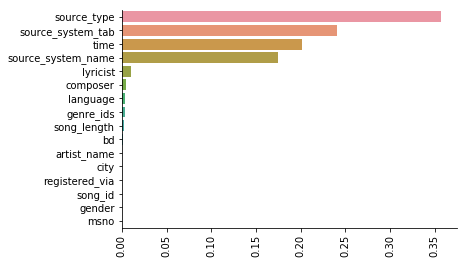

In [143]:
import pyspark.sql as sparksql
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

idx = np.array(featuresCols)
importance = np.array([0.0, 0.0001, 0.2404, 0.1743, 0.3567, 0.0026, 0.0034, 0.0006, 0.0044, 0.0104, 0.0041, 0.0002, 0.0008, 0.0, 0.0001, 0.202])

arr1inds = importance.argsort()
sorted_idx = idx[arr1inds[::-1]]
sorted_importance = importance[arr1inds[::-1]]

sns.barplot(x=sorted_importance, y=sorted_idx, orient= 'h')
plt.xticks(rotation='vertical')
sns.despine()

In [27]:
# Run model on test data: prepare test data features
#featuresCols_test = test.drop("target").drop("expiration_date").drop("registration_init_time").columns
# assembler_test = VectorAssembler(inputCols = featuresCols, outputCol="features")

In [28]:
# assembled_test = assembler_test.transform(test)

In [139]:
# Fit test data
predictions_test = pipe_model.transform(test)

In [144]:
predictions_test.limit(10).toPandas()

/opt/spark/current/python/pyspark/sql/dataframe.py:2102: UserWarning: toPandas attempted Arrow optimization because 'spark.sql.execution.arrow.enabled' is set to true; however, failed by the reason below:
  Unsupported type in conversion to Arrow: VectorUDT
Attempting non-optimization as 'spark.sql.execution.arrow.fallback.enabled' is set to true.
  warnings.warn(msg)


,msno,song_id,source_system_tab,source_system_name,source_type,target,song_length,genre_ids,artist_name,composer,...,bd,gender,registered_via,registration_init_time,expiration_date,time,features,rawPrediction,probability,prediction
0,17724,228222,8,3,3,NaN,224130.0,364,42813,56689,...,0,2,2,2016-02-19,2017-09-18,0.742628,"[17724.0, 228222.0, 8.0, 3.0, 3.0, 224130.0, 3...","[42.38552737267208, 57.61447262732795]","[0.42385527372672066, 0.5761447262732793]",1.0
1,17724,407039,8,3,3,NaN,320470.0,371,42633,79915,...,0,2,2,2016-02-19,2017-09-18,0.742628,"[17724.0, 407039.0, 8.0, 3.0, 3.0, 320470.0, 3...","[41.44740823643115, 58.55259176356888]","[0.4144740823643114, 0.5855259176356886]",1.0
2,977,70211,22,0,10,NaN,315899.0,200,38492,73206,...,0,2,1,2016-11-17,2016-11-24,0.742628,"[977.0, 70211.0, 22.0, 0.0, 10.0, 315899.0, 20...","[62.74507909251591, 37.25492090748408]","[0.6274507909251592, 0.37254920907484085]",0.0
3,1878,419092,16,6,8,NaN,285210.0,371,36423,67327,...,30,1,3,2007-07-25,2017-04-30,0.742628,"[1878.0, 419092.0, 16.0, 6.0, 8.0, 285210.0, 3...","[66.66273211402333, 33.33726788597669]","[0.666627321140233, 0.33337267885976685]",0.0
4,1878,160096,16,6,8,NaN,197590.0,519,38298,52438,...,30,1,3,2007-07-25,2017-04-30,0.742628,"[1878.0, 160096.0, 16.0, 6.0, 8.0, 197590.0, 5...","[66.64790187667326, 33.35209812332674]","[0.6664790187667325, 0.3335209812332674]",0.0
5,1878,167673,16,6,8,NaN,216372.0,371,19587,74276,...,30,1,3,2007-07-25,2017-04-30,0.742628,"[1878.0, 167673.0, 16.0, 6.0, 8.0, 216372.0, 3...","[66.66834131925383, 33.33165868074619]","[0.6666834131925382, 0.33331658680746185]",0.0
6,1878,101220,16,6,8,NaN,200306.0,371,4754,35319,...,30,1,3,2007-07-25,2017-04-30,0.742628,"[1878.0, 101220.0, 16.0, 6.0, 8.0, 200306.0, 3...","[66.09729766101755, 33.90270233898246]","[0.6609729766101755, 0.3390270233898246]",0.0
7,1878,140039,8,3,4,NaN,344305.0,364,40805,76756,...,30,1,3,2007-07-25,2017-04-30,0.742628,"[1878.0, 140039.0, 8.0, 3.0, 4.0, 344305.0, 36...","[42.10828003973182, 57.89171996026821]","[0.42108280039731805, 0.578917199602682]",1.0
8,1878,46416,16,6,8,NaN,289332.0,371,40937,76999,...,30,1,3,2007-07-25,2017-04-30,0.742629,"[1878.0, 46416.0, 16.0, 6.0, 8.0, 289332.0, 37...","[64.99575739376627, 35.004242606233724]","[0.6499575739376627, 0.35004242606233726]",0.0
9,2927,130708,8,3,3,NaN,232176.0,371,3344,74276,...,0,2,2,2015-12-19,2017-09-18,0.742629,"[2927.0, 130708.0, 8.0, 3.0, 3.0, 232176.0, 37...","[43.01141659656859, 56.98858340343144]","[0.43011416596568575, 0.5698858340343143]",1.0


### Model 2: Multilayer Perceptron Classifier

In [151]:
# Set up model parameters
from pyspark.ml.classification import MultilayerPerceptronClassifier

layers = [16, 4, 2]

# create the trainer and set its parameters
mp = MultilayerPerceptronClassifier(labelCol='target', maxIter=120, layers=layers, blockSize=3000, seed=1234)

In [152]:
# Pipeline
pipeline_mp = Pipeline(stages=[assembler, mp])

In [ ]:
# Fit train data
mp_model = pipeline_mp.fit(train)

In [70]:
# Use the fitted model to obtain predictions on the validation set
mp_predictions = mp_model.transform(train)

In [71]:
# Validation Result
evaluation_metric(mp_predictions)

AUC: 0.499 f1: 0.337 Accuracy: 0.504 Weighted Precision: 0.750 Weighted Recall: 0.504


In [72]:
# Fit the model on test data
mp_predictions_test = mp_model.transform(test)

In [73]:
mp_predictions_test.limit(10).toPandas()

,msno,song_id,source_system_tab,source_system_name,source_type,target,song_length,genre_ids,artist_name,composer,...,bd,gender,registered_via,registration_init_time,expiration_date,time,features,rawPrediction,probability,prediction
0,17724,228222,8,3,3,NaN,224130.0,364,42813,56689,...,0,2,2,2016-02-19,2017-09-18,0.742628,"[17724.0, 228222.0, 8.0, 3.0, 3.0, 224130.0, 3...","[-0.19989867784937207, -0.18842494514837477]","[0.49713159829261216, 0.5028684017073879]",1.0
1,17724,407039,8,3,3,NaN,320470.0,371,42633,79915,...,0,2,2,2016-02-19,2017-09-18,0.742628,"[17724.0, 407039.0, 8.0, 3.0, 3.0, 320470.0, 3...","[-0.19989867784937207, -0.18842494514837477]","[0.49713159829261216, 0.5028684017073879]",1.0
2,977,70211,22,0,10,NaN,315899.0,200,38492,73206,...,0,2,1,2016-11-17,2016-11-24,0.742628,"[977.0, 70211.0, 22.0, 0.0, 10.0, 315899.0, 20...","[-0.2709384231077888, -0.24931305981227747]","[0.49459386985873194, 0.505406130141268]",1.0
3,1878,419092,16,6,8,NaN,285210.0,371,36423,67327,...,30,1,3,2007-07-25,2017-04-30,0.742628,"[1878.0, 419092.0, 16.0, 6.0, 8.0, 285210.0, 3...","[-0.19989867784937207, -0.18842494514837477]","[0.49713159829261216, 0.5028684017073879]",1.0
4,1878,160096,16,6,8,NaN,197590.0,519,38298,52438,...,30,1,3,2007-07-25,2017-04-30,0.742628,"[1878.0, 160096.0, 16.0, 6.0, 8.0, 197590.0, 5...","[-0.19989867784937207, -0.18842494514837477]","[0.49713159829261216, 0.5028684017073879]",1.0
5,1878,167673,16,6,8,NaN,216372.0,371,19587,74276,...,30,1,3,2007-07-25,2017-04-30,0.742628,"[1878.0, 167673.0, 16.0, 6.0, 8.0, 216372.0, 3...","[-0.19989867784937207, -0.18842494514837477]","[0.49713159829261216, 0.5028684017073879]",1.0
6,1878,101220,16,6,8,NaN,200306.0,371,4754,35319,...,30,1,3,2007-07-25,2017-04-30,0.742628,"[1878.0, 101220.0, 16.0, 6.0, 8.0, 200306.0, 3...","[-0.19989867784937207, -0.18842494514837477]","[0.49713159829261216, 0.5028684017073879]",1.0
7,1878,140039,8,3,4,NaN,344305.0,364,40805,76756,...,30,1,3,2007-07-25,2017-04-30,0.742628,"[1878.0, 140039.0, 8.0, 3.0, 4.0, 344305.0, 36...","[-0.19989867784937207, -0.18842494514837477]","[0.49713159829261216, 0.5028684017073879]",1.0
8,1878,46416,16,6,8,NaN,289332.0,371,40937,76999,...,30,1,3,2007-07-25,2017-04-30,0.742629,"[1878.0, 46416.0, 16.0, 6.0, 8.0, 289332.0, 37...","[-0.2709384231077888, -0.24931305981227747]","[0.49459386985873194, 0.505406130141268]",1.0
9,2927,130708,8,3,3,NaN,232176.0,371,3344,74276,...,0,2,2,2015-12-19,2017-09-18,0.742629,"[2927.0, 130708.0, 8.0, 3.0, 3.0, 232176.0, 37...","[-0.19989867784937207, -0.18842494514837477]","[0.49713159829261216, 0.5028684017073879]",1.0
